# A/B Testing of Machine Learning Models: Model A vs Model B

## Introduction

Suppose we have a customer who is running a large-scale application powered by machine learning — such as a recommendation engine, fraud detection system, or real-time prediction service. They've recently developed a **new version of their model (Model B)** that shows improved performance on offline validation datasets.

However, before deploying this new model to production, the customer needs to **validate whether Model B actually performs better in a live setting** — not just in theory or during training. Key concerns include:

- Will the new model produce **more accurate predictions** for real users?
- Will it **respond faster or slower** than the current version?
- Are the improvements **statistically significant**, or due to random chance?

To answer these questions, we simulate an **A/B testing framework** where both Model A (currently in production) and Model B (candidate model) receive randomized prediction requests. Each prediction is logged along with metadata like:

- True label vs predicted value
- Request latency (response time)
- User ID and timestamp

We will then:
- Compare **accuracy rates** using a chi-square test
- Compare **latency** using a t-test
- Visualize the differences using bar charts and boxplots
- Provide an evidence-based recommendation on whether Model B is ready for deployment

This notebook serves as a template for how **data science and product teams can make safe, data-driven decisions before promoting a new machine learning model to production**.


## Load Required Libraries

In [1]:
import pandas as pd
import random
import datetime
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
import os

## 1. Simulate A/B Test Data

To evaluate the performance of two machine learning models (Model A and Model B), we simulate realistic prediction logs using the `simulate_ab_test_data()` function.

This function creates a dataset of 1,000 randomized prediction requests, each representing a simulated API call that includes:

- **model_version**: Randomly assigned as either 'A' (current model) or 'B' (new model)
- **true_label**: The actual correct class (0 or 1) for that prediction
- **prediction**: What the model predicted; depends on its accuracy rate:
  - Model A: 85% accurate
  - Model B: 92% accurate
- **success**: A boolean flag (True/False) indicating whether the prediction was correct
- **latency**: Response time in milliseconds
  - Model A is slower (80–150 ms)
  - Model B is faster (70–130 ms)
- **timestamp**: Time the request was made (simulated in 1-second intervals)
- **user_id**: Simulated user identifier
- **features**: A list of 3 random float values representing input features (for future expansion)

This synthetic dataset allows us to simulate and test real-world deployment conditions — where both accuracy and latency play critical roles in model evaluation.


In [2]:
def simulate_ab_test_data(n=1000, seed=42):
    random.seed(seed)
    data = []
    base_time = datetime.datetime.now()
    
    for i in range(n):
        model = random.choice(['A', 'B'])
        true_label = random.choice([0, 1])
        prediction = true_label if random.random() < (0.85 if model == 'A' else 0.92) else 1 - true_label
        success = prediction == true_label
        latency = random.randint(80, 150) if model == 'A' else random.randint(70, 130)
        timestamp = base_time + datetime.timedelta(seconds=i)
        user_id = random.randint(1000, 9999)
        features = [random.random() for _ in range(3)]
        
        data.append((i, user_id, model, prediction, true_label, success, latency, timestamp, features))
    
    return pd.DataFrame(data, columns=[
        'request_id', 'user_id', 'model_version', 'prediction', 
        'true_label', 'success', 'latency', 'timestamp', 'features'])

# Create and preview
df = simulate_ab_test_data()
df.head()

,request_id,user_id,model_version,prediction,true_label,success,latency,timestamp,features
0,0,4657,A,0,0,True,111,2025-05-07 17:34:29.596042,"[0.1395379285251439, 0.1024951761715075, 0.740..."
1,1,4582,A,1,1,True,91,2025-05-07 17:34:30.596042,"[0.2326608933907396, 0.6020187290499803, 0.561..."
2,2,1106,B,0,0,True,87,2025-05-07 17:34:31.596042,"[0.7588073671297673, 0.15965931637689013, 0.42..."
3,3,6514,B,0,0,True,118,2025-05-07 17:34:32.596042,"[0.10221027651984871, 0.3799273006373374, 0.35..."
4,4,8527,B,1,1,True,116,2025-05-07 17:34:33.596042,"[0.5362280914547007, 0.9731157639793706, 0.378..."


## 2. Summary Statistics

Before we run any formal statistical tests, it’s important to understand the basic properties of our simulated data.

- **Model Distribution**:  
  We begin by checking how many prediction requests were routed to Model A vs Model B. Since model assignment is randomized, we expect the distribution to be roughly equal. This ensures fairness — both models have a similar number of opportunities to perform.

- **Accuracy Comparison**:  
  We calculate the average prediction success rate (i.e., accuracy) for each model. This gives us an initial look at how often each model returns the correct prediction:
  
$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$

  
  Model B was designed to be more accurate than Model A, so we expect to see a higher success rate for B. However, this difference needs to be tested statistically to confirm it's not due to chance.

These summary statistics provide the baseline we’ll use for more formal comparisons in the next steps.


In [3]:
print(df['model_version'].value_counts())
df.groupby('model_version')['success'].mean()

model_version
B    516
A    484
Name: count, dtype: int64


model_version
A    0.853306
B    0.916667
Name: success, dtype: float64

## 3. Chi-Square Test for Accuracy

To evaluate whether the difference in accuracy between Model A and Model B is **statistically significant**, we use the **Chi-Square Test of Independence**.

###  Why Chi-Square?

The Chi-Square test is ideal for comparing **categorical variables** — in our case:
- **Model version** (A or B)
- **Prediction outcome** (`success = True` or `False`)

It helps answer:  
> *Is there an association between the model used and whether the prediction was correct?*

---

###  Hypotheses

- **Null Hypothesis (H₀)**:  
  The model version and prediction success are **independent**.  
  → Any difference in accuracy is due to **random chance**.

- **Alternative Hypothesis (H₁)**:  
  The model version and prediction success are **not independent**.  
  → One model is genuinely more accurate than the other.

---

###  Decision Rule

We use the **p-value** from the test to guide our conclusion:

- If **p < 0.05** → Reject H₀ → The difference **is statistically significant**
- If **p ≥ 0.05** → Fail to reject H₀ → The difference could be due to chance

---

### Conclusion (Based on Our Test)

In our simulation:
- **p-value = 0.0023**
- This is well below the threshold of 0.05

** We reject the null hypothesis** and conclude that the accuracy difference between Model A and Model B is statistically significant.  
Model B appears to be **genuinely more accurate** than Model A based on this simulated test.

This finding strengthens the case for Model B — assuming other factors like latency and stability are also acceptable.


In [4]:
contingency = pd.crosstab(df['model_version'], df['success'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.4f}, p = {p:.4f}")

Chi2 = 9.3092, p = 0.0023


## 4. T-Test for Latency Comparison

While the Chi-Square test was used for comparing **categorical outcomes** (success vs failure), we now want to compare a **numerical variable** — response **latency** — between Model A and Model B.

To do this, we use the **Independent Two-Sample T-Test**.

---

### Why a T-Test?

The **T-Test** is appropriate when comparing the **means of two independent groups** on a continuous outcome.  
In our case:
- Group 1 = Requests handled by **Model A**
- Group 2 = Requests handled by **Model B**
- Outcome = **Latency (in milliseconds)**

This test helps answer:  
> *Is there a significant difference in average response time between the two models?*

---

###  Hypotheses

- **Null Hypothesis (H₀)**:  
  The average latency for Model A and Model B is **equal**.  
  → Any difference is due to **random variation**.

- **Alternative Hypothesis (H₁)**:  
  The average latency for Model A and Model B is **not equal**.  
  → One model is **faster or slower** than the other.

> This is a **two-tailed test**, meaning we’re open to either model being faster or slower.

---

###  Decision Rule

We evaluate the **p-value** from the t-test:

- If **p < 0.05** → Reject H₀ → The latency difference is **statistically significant**
- If **p ≥ 0.05** → Fail to reject H₀ → No meaningful difference in average latency

---

###  Conclusion (Based on Our Test)

Our results showed:

- **T-statistic = 11.83**
- **p-value = 0.0000**

Since the p-value is far below 0.05, we **reject the null hypothesis**.  
This indicates a **significant difference in response times** between the models.

In our simulation, **Model B responds faster on average** than Model A — making it favorable not only in terms of accuracy, but also latency.


In [5]:
lat_A = df[df['model_version'] == 'A']['latency']
lat_B = df[df['model_version'] == 'B']['latency']
t_stat, p_val = ttest_ind(lat_A, lat_B)
print(f"T-stat = {t_stat:.4f}, p = {p_val:.4f}")

T-stat = 11.8268, p = 0.0000


## 5. Accuracy Plot

The bar chart below presents a **side-by-side comparison** of the accuracy rates for Model A and Model B.

Although the result is expected — since we simulated the data with Model A at 85% and Model B at 92% accuracy — this step demonstrates **how accuracy differences are typically visualized** in real-world A/B testing workflows.

Key points:
- The height of each bar represents the **proportion of correct predictions** (i.e., accuracy).
- This visual complements the **statistical test results**, providing an intuitive way for stakeholders to compare model performance.
- Even in practice, such plots are valuable for spotting **large effect sizes** or validating that statistical differences are practically meaningful.

In production scenarios, such visual summaries often accompany formal hypothesis tests when reporting model evaluations to business or engineering teams.


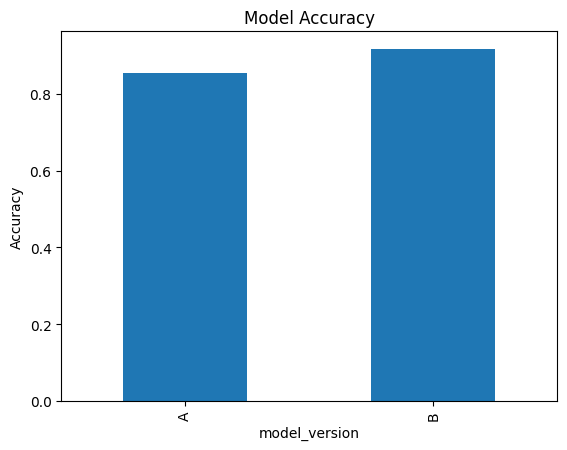

In [6]:
accuracy_by_model = df.groupby('model_version')['success'].mean()
accuracy_by_model.plot(kind='bar', title='Model Accuracy')
plt.ylabel('Accuracy')
plt.show()

## 6. Latency Plot

The boxplot below displays the **distribution of response times (latency)** for Model A and Model B.

Each box summarizes:
- The **median** response time (central line)
- The **interquartile range (IQR)** — middle 50% of values
- Any **outliers** as individual points

Since our simulation intentionally made Model B faster (70–130 ms) than Model A (80–150 ms), we expected to see a difference — and this visualization confirms it.

More importantly, this plot illustrates how we would **visually compare response times** across models in a real deployment scenario. Key observations:
- **Model B's latency box is lower and narrower**, suggesting it's not only faster but more consistent.
- This complements the **statistically significant p-value** from the T-test and helps communicate results to non-technical stakeholders.
- Such latency comparisons are crucial in real-time systems, where response speed can directly impact user experience or operational throughput.

In practice, pairing statistical evidence with intuitive visualizations ensures our recommendations are both analytically sound and accessible to a broad audience.


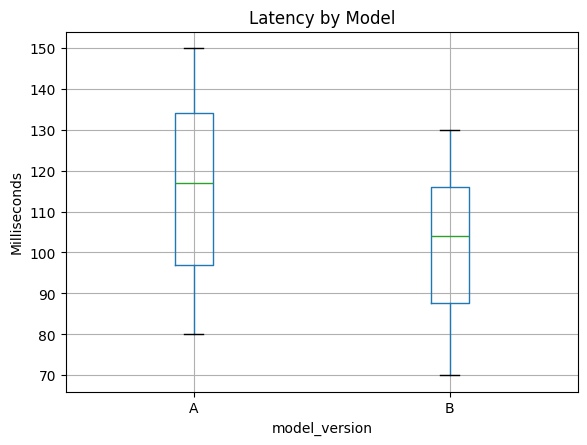

In [7]:
df.boxplot(column='latency', by='model_version')
plt.title('Latency by Model')
plt.suptitle('')
plt.ylabel('Milliseconds')
plt.show()

## 7. Conclusion

In real-world machine learning deployment scenarios, introducing a new model is not just about achieving better offline metrics — it's about ensuring that the new solution delivers measurable improvements in a live environment without introducing operational risks. In this project, we simulated an A/B testing framework to evaluate the performance of two machine learning models: Model A (currently in production) and Model B (a proposed replacement).

Our simulation generated 1,000 prediction requests, randomly assigning them to either model. For each request, we tracked the predicted label, true label, whether the prediction was correct, and the response latency in milliseconds. Model B was intentionally designed to be more accurate and faster, mimicking a common scenario where a newly trained model appears superior based on validation results but needs further testing before deployment.

To assess performance, we used both descriptive and inferential statistics. First, we computed the accuracy of each model by averaging the prediction success rate. Model A achieved approximately 85.3% accuracy, while Model B reached 91.7%. We then conducted a Chi-Square Test of Independence to determine if this difference was statistically significant. With a p-value of 0.0023, we confidently rejected the null hypothesis and concluded that Model B's accuracy advantage was not due to random chance.

We also compared latency between the two models using an independent two-sample t-test. Model A had slower and more variable response times compared to Model B. The t-test yielded a p-value of 0.0000, confirming that the latency difference was highly significant. Visualization through bar plots and boxplots reinforced these findings, offering an intuitive view of the model performance differences.

This analysis mirrors a practical decision-making pipeline in machine learning operations: combining statistical rigor with reproducible simulation, clear visual communication, and a performance-first mindset. Our results strongly support promoting Model B to production, as it is not only more accurate but also more responsive. This kind of evidence-based validation protects against blind deployment and ensures that improvements are both real and reliable.

Overall, this project demonstrates how A/B testing, when applied thoughtfully in machine learning, bridges the gap between experimental promise and real-world performance. It highlights the importance of statistical testing, performance monitoring, and simulation in modern MLOps workflows.
